# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tableone import TableOne
import torch
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization

from synthcity.metrics.plots import plot_tsne
from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [3]:
dataset_name = "gbsg2"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [4]:
control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
control = pd.read_csv(data_file_control, header=None, names=control_fnames)
print(control.head())

     time  censor   age  ER  menostat  pnodes  PR  tgrade  tsize
0  1814.0       1  70.0   1         1     3.0   1       2   21.0
1   772.0       1  73.0   1         1     1.0   1       2   35.0
2   448.0       1  32.0   0         0    24.0   0       3   57.0
3  2161.0       0  65.0   1         1     1.0   1       2   16.0
4   471.0       1  80.0   1         1    30.0   0       2   39.0


In [5]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)

In [6]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [7]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

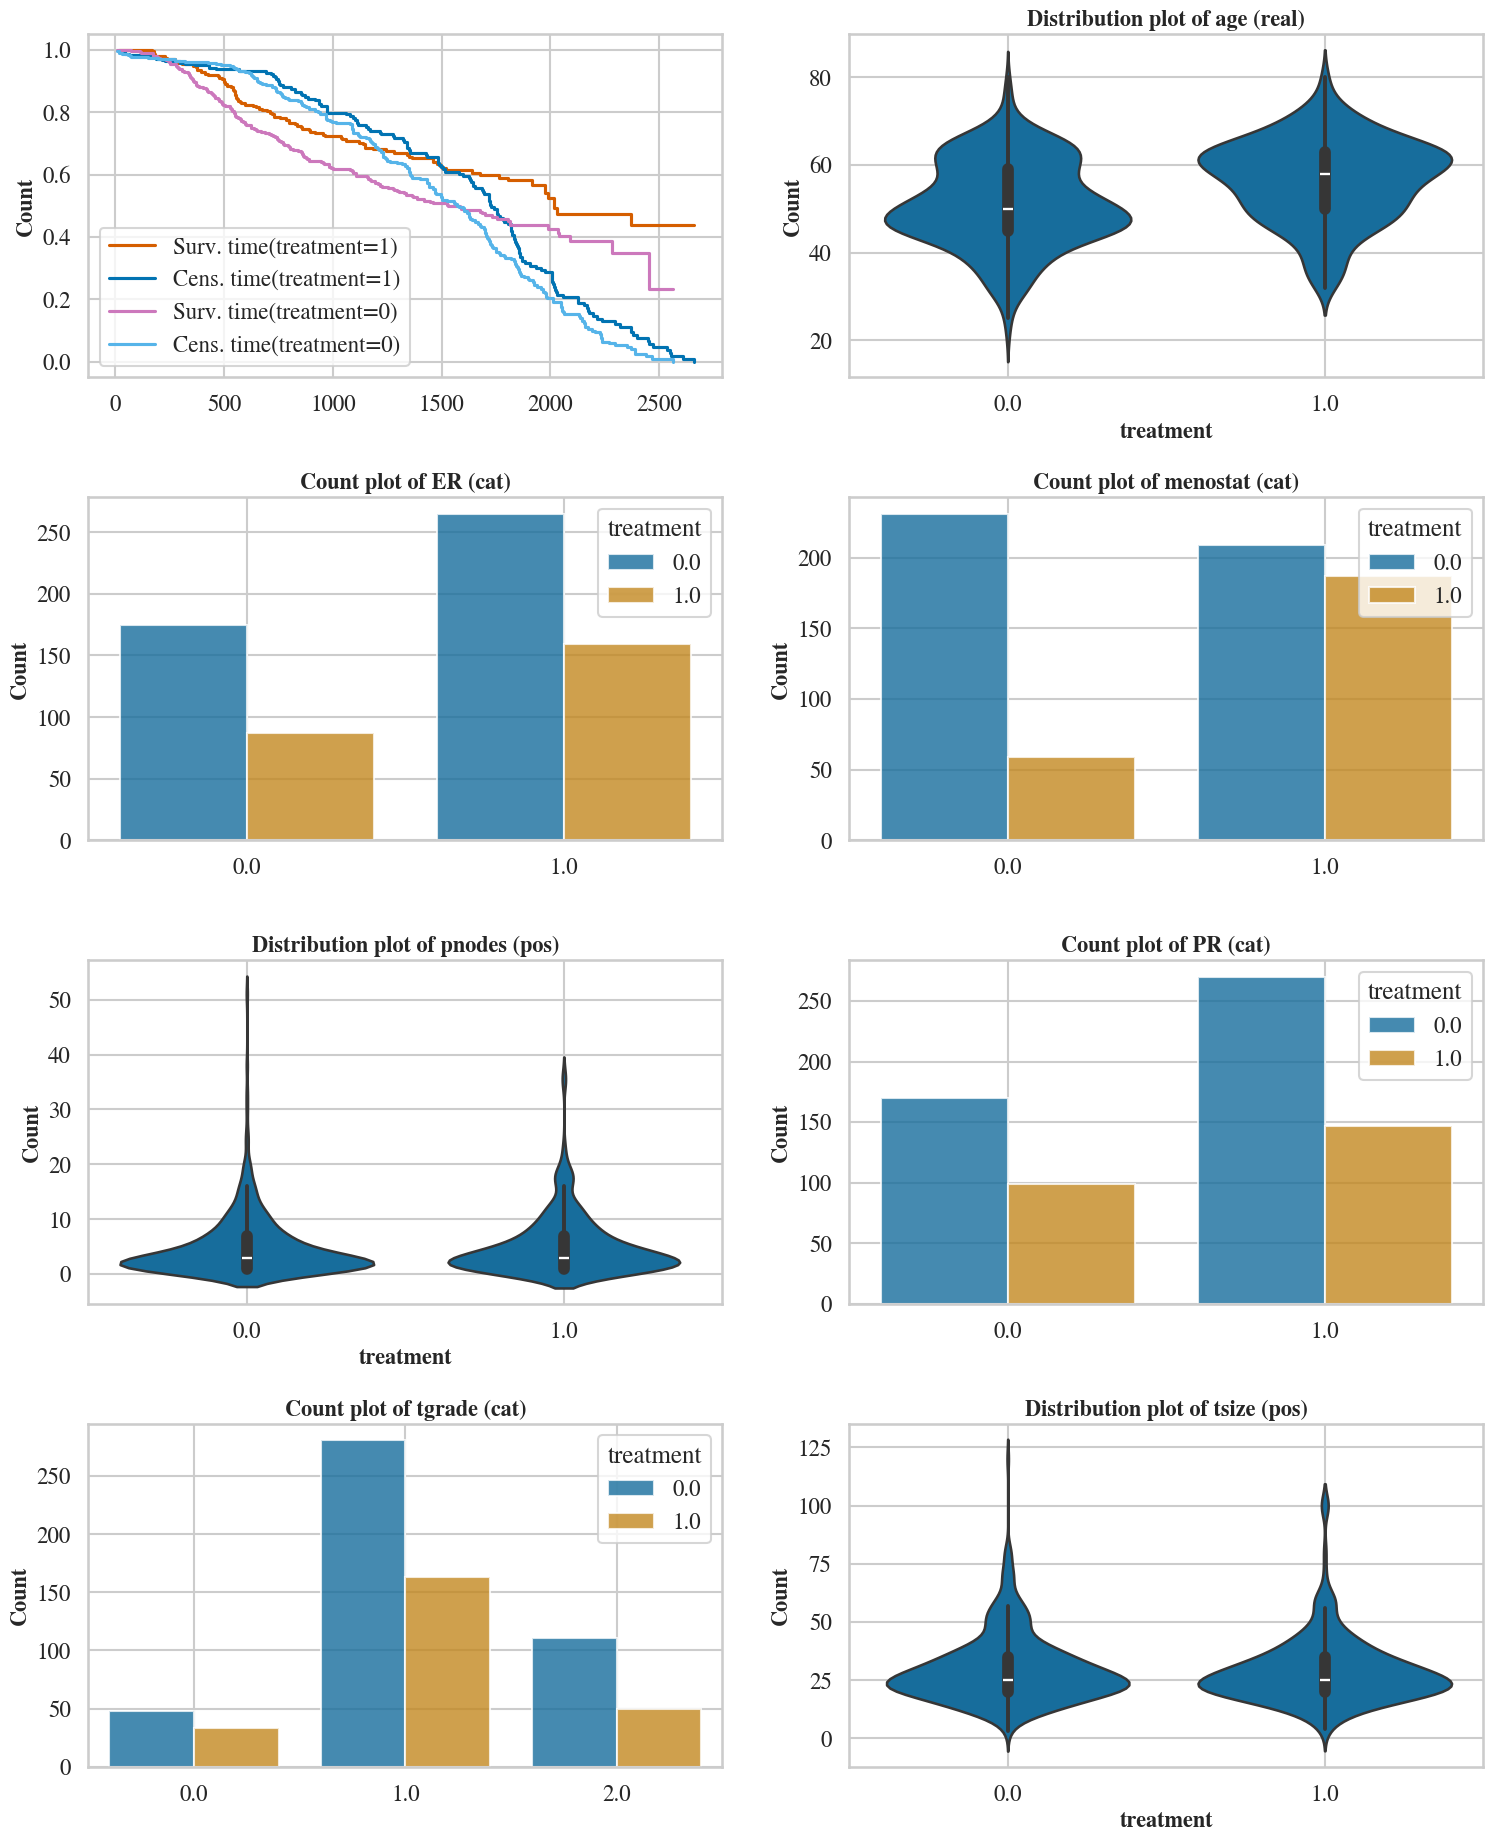

In [8]:
# TODO: Refactor
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [24]:
categorical = ['censor','ER','menostat','PR', 'tgrade','treatment']
continuous = ['time','age', 'pnodes', 'tsize']
nonnormal = ['time','age', 'pnodes', 'tsize']

table1 = TableOne(df_init, categorical=categorical, continuous=continuous, 
                  groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                           Grouped by treatment                                                                            
                                        Missing                Overall                     0                      1 P-Value
n                                                                  686                   440                    246        
time, median [Q1,Q3]                          0  1084.0 [567.8,1684.8]  967.0 [547.8,1573.0]  1220.5 [695.8,1818.0]   0.001
censor, n (%)          0.0                                  387 (56.4)            235 (53.4)             152 (61.8)   0.041
                       1.0                                  299 (43.6)            205 (46.6)              94 (38.2)        
age, median [Q1,Q3]                           0       53.0 [46.0,61.0]      50.0 [45.0,59.0]       58.0 [50.0,63.0]  <0.001
ER, n (%)              0.0                                  262 (38.2)            175 (39.8)              87 (35.4)   0.290
        

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [11]:
from execute import surv_hivae

# the datasets used for training is data_init_control
n_generated_dataset = 100

In [12]:
data_gen_control = surv_hivae.run(df_init_control_encoded,
                                  miss_mask_control, 
                                  true_miss_mask_control,
                                  feat_types_dict,
                                  n_generated_dataset)

Epoch: [ 0]  time: 0.0795, ELBO_train: -16.45255280, KL_z: 1.49621952, KL_s: 0.08289854, reconstruction loss: -14.87343474
Epoch: [100]  time: 3.6605, ELBO_train: -14.03695838, KL_z: 0.49962380, KL_s: 0.03004479, reconstruction loss: -13.50728979
Epoch: [200]  time: 7.1469, ELBO_train: -13.69251569, KL_z: 0.73520815, KL_s: 0.02784014, reconstruction loss: -12.92946740
Epoch: [300]  time: 10.8787, ELBO_train: -13.76746845, KL_z: 0.92235792, KL_s: 0.03125016, reconstruction loss: -12.81386038
Epoch: [400]  time: 14.4101, ELBO_train: -13.54753526, KL_z: 1.02641356, KL_s: 0.02982966, reconstruction loss: -12.49129204
Epoch: [500]  time: 18.0815, ELBO_train: -13.45900663, KL_z: 1.16303205, KL_s: 0.03107516, reconstruction loss: -12.26489941
Epoch: [600]  time: 21.1990, ELBO_train: -13.71520869, KL_z: 1.25168526, KL_s: 0.03038295, reconstruction loss: -12.43314048
Epoch: [700]  time: 24.7604, ELBO_train: -13.23818843, KL_z: 1.31351463, KL_s: 0.03293602, reconstruction loss: -11.89173778
Epoc

## 3. Analyze the generated data

### 3.1. Statistical analysis: one generated control group vs. initial control data

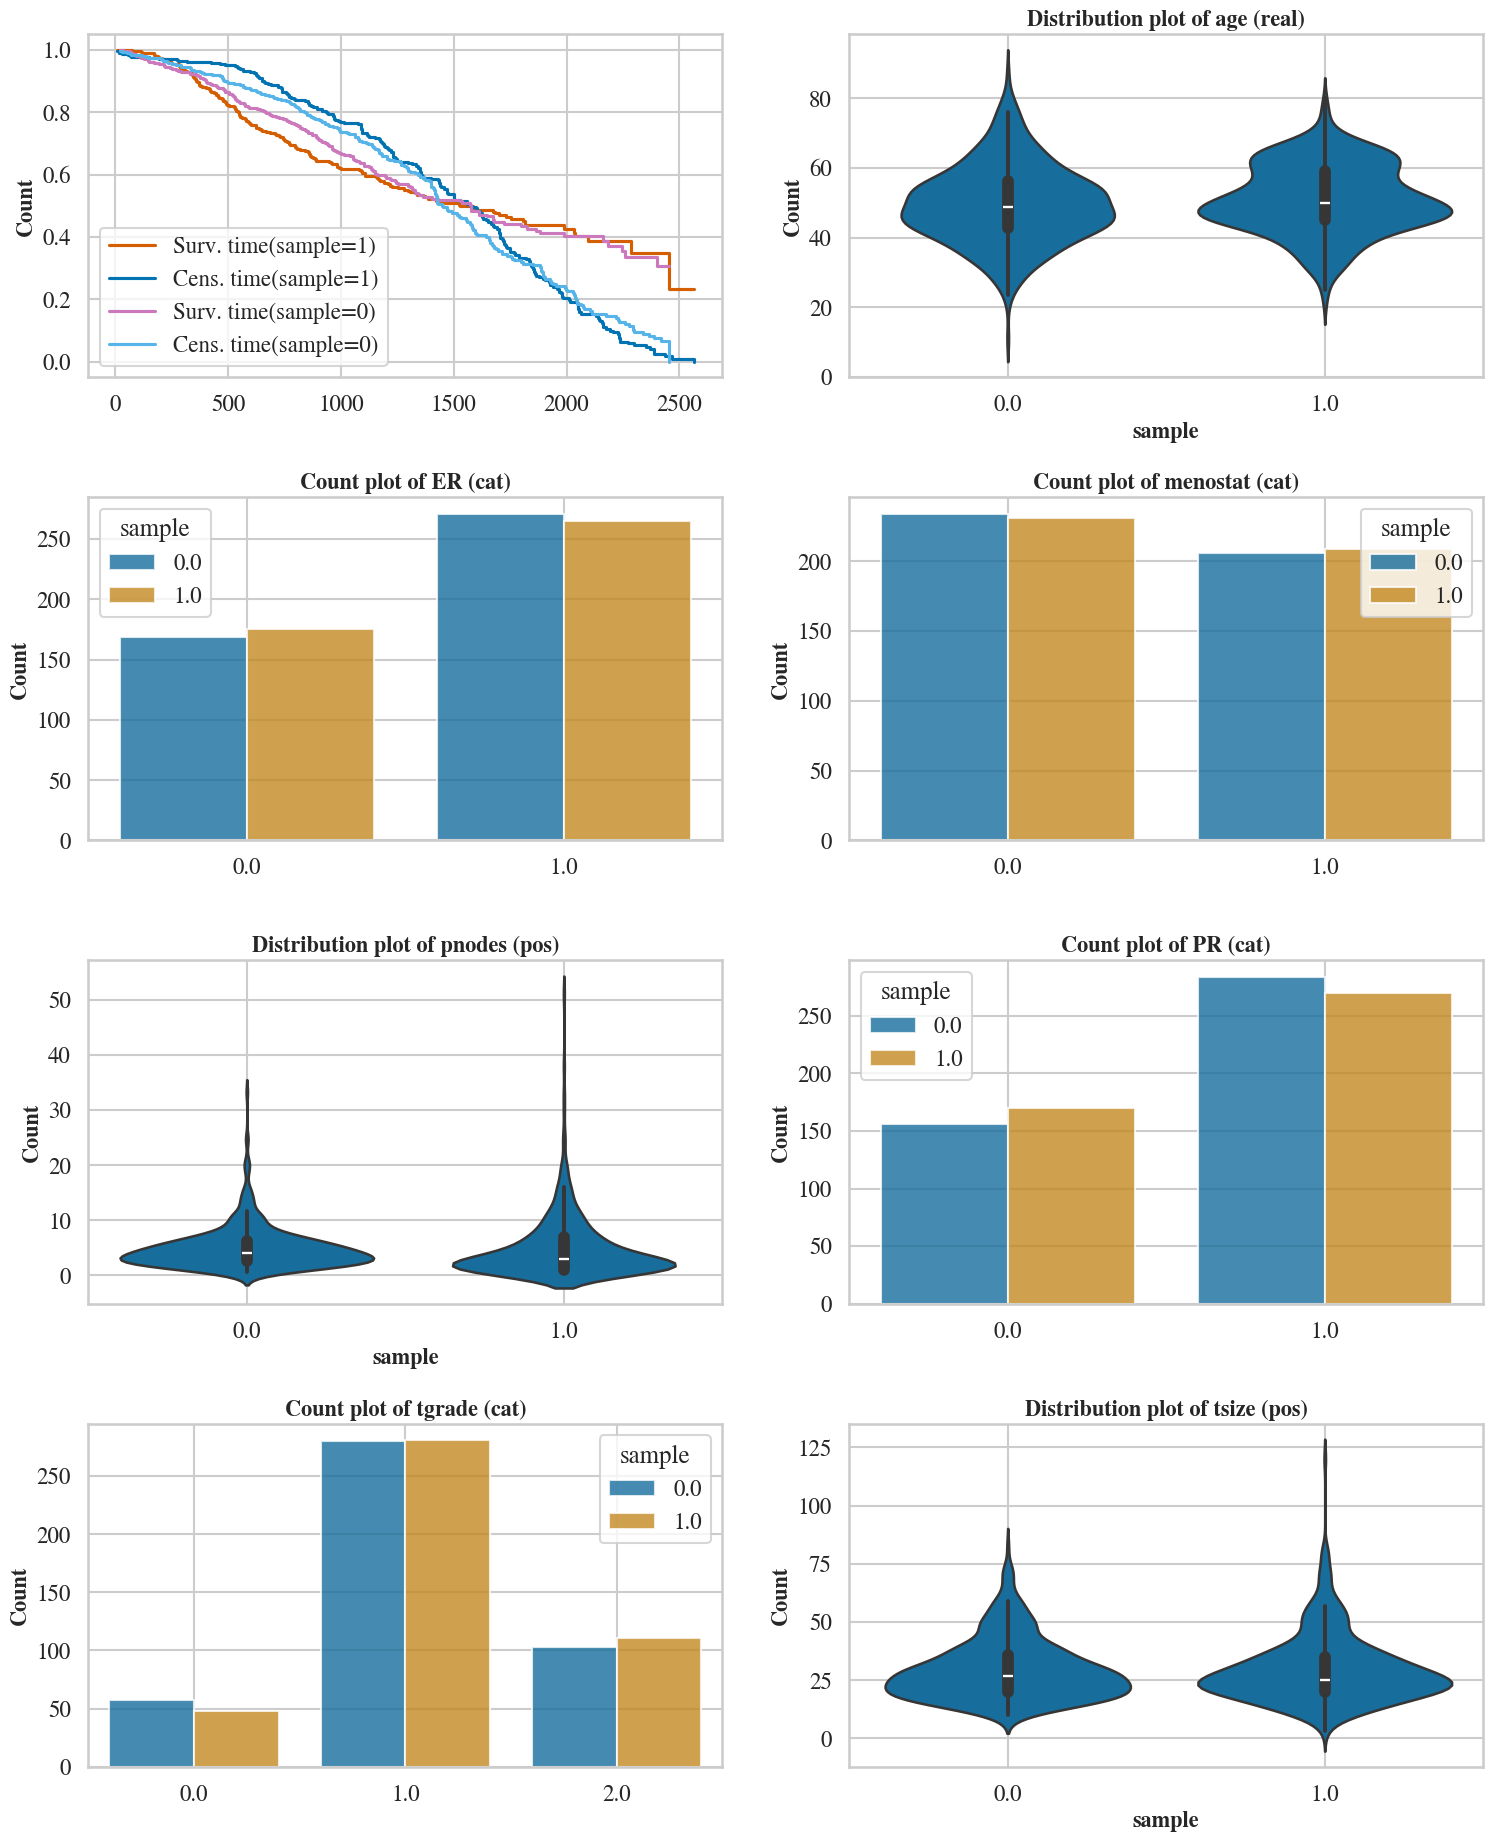

In [13]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)
df_init_control_ext['sample'] = 1

sel_idx = 2
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=control_fnames)
df_gen_control_ext_sel['sample'] = 0

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [14]:
categorical = ['censor','ER','menostat','PR', 'tgrade','sample']
continuous = ['time','age', 'pnodes', 'tsize']
nonnormal = ['time','age', 'pnodes', 'tsize']



table1 = TableOne(df_control_sel, categorical=categorical, continuous=continuous, groupby='sample', nonnormal=nonnormal, pval=True)
print(table1)

                           Grouped by sample                                                                          
                                     Missing               Overall                     0                     1 P-Value
n                                                              880                   440                   440        
time, median [Q1,Q3]                       0  977.5 [544.8,1527.2]  992.4 [535.5,1477.4]  967.0 [547.8,1573.0]   0.910
censor, n (%)          0.0                              480 (54.5)            245 (55.7)            235 (53.4)   0.542
                       1.0                              400 (45.5)            195 (44.3)            205 (46.6)        
age, median [Q1,Q3]                        0      49.4 [43.6,57.5]      48.8 [42.7,56.4]      50.0 [45.0,59.0]   0.024
ER, n (%)              0.0                              344 (39.1)            169 (38.4)            175 (39.8)   0.730
                       1.0                      

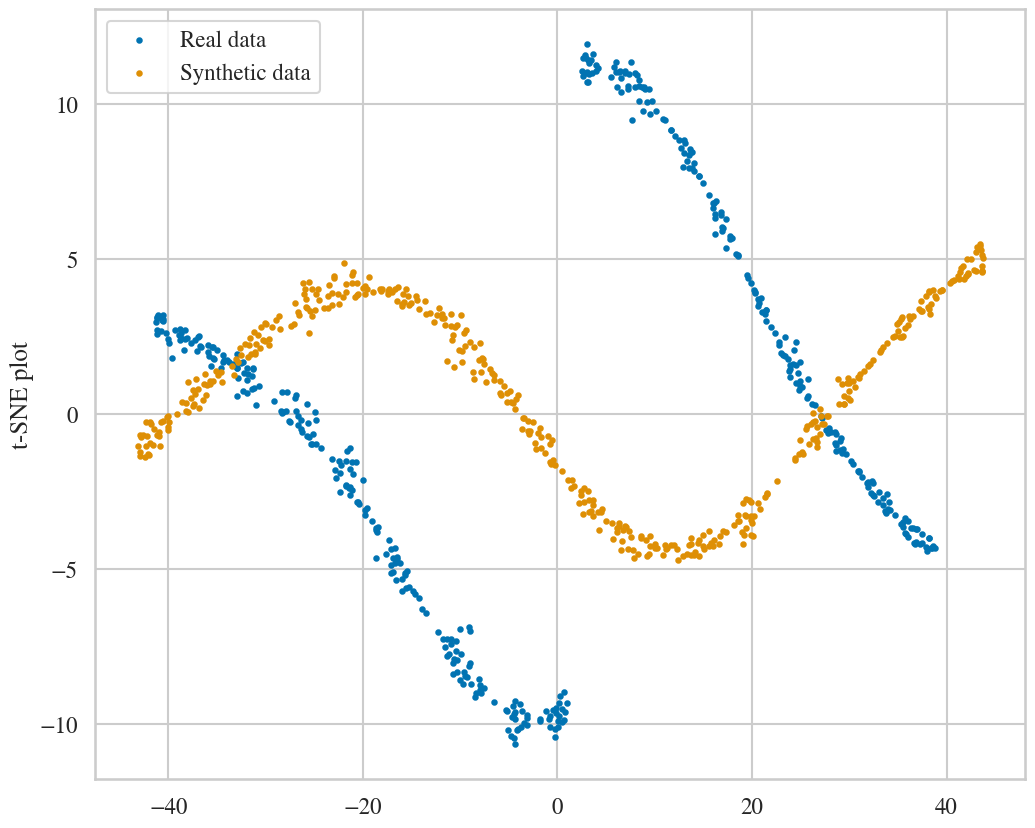

In [15]:
synthcity_dataloader_init = SurvivalAnalysisDataLoader(df_init_control, target_column = "censor", time_to_event_column = "time")
synthcity_dataloader_syn = SurvivalAnalysisDataLoader(df_gen_control_ext_sel, target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, synthcity_dataloader_init, synthcity_dataloader_syn)

### 3.2. Statistical analysis: one generated control group vs. initial treated data

In [16]:
list_df_gen_control = []
for j in range(n_generated_dataset):
    df_gen_control_j = pd.DataFrame(data_gen_control[j].numpy(), columns=control_fnames)
    df_gen_control_j['treatment'] = 0
    list_df_gen_control.append(df_gen_control_j)

sel_idx = 0
df_gen_control_sel = list_df_gen_control[sel_idx]
df_syn_sel = pd.concat([df_init_treated, df_gen_control_sel], ignore_index=True)

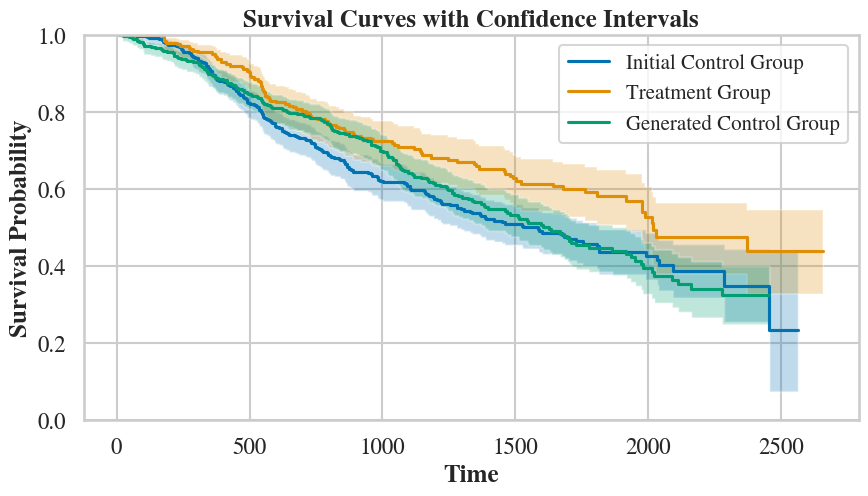

In [17]:
surv_time_control_init = df_init[df_init['treatment']==0].to_numpy()[:,0]
surv_ind_control_init = df_init[df_init['treatment']==0].to_numpy()[:,1].astype(bool)
surv_time_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,0]
surv_ind_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,1].astype(bool)
surv_time_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,0]
surv_ind_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,1].astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")

plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [19]:
categorical = ['censor','ER','menostat','PR', 'tgrade','treatment']
continuous = ['time','age', 'pnodes', 'tsize']
nonnormal = ['time','age', 'pnodes', 'tsize']

table1 = TableOne(df_syn_sel, categorical=categorical, continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                           Grouped by treatment                                                                             
                                        Missing                Overall                      0                      1 P-Value
n                                                                  686                    440                    246        
time, median [Q1,Q3]                          0  1064.2 [551.2,1644.7]  1017.7 [518.7,1470.0]  1220.5 [695.8,1818.0]  <0.001
censor, n (%)          0.0                                  402 (58.6)             250 (56.8)             152 (61.8)   0.235
                       1.0                                  284 (41.4)             190 (43.2)              94 (38.2)        
age, median [Q1,Q3]                           0       53.0 [44.1,61.0]       49.8 [42.0,57.8]       58.0 [50.0,63.0]  <0.001
ER, n (%)              0.0                                  257 (37.5)             170 (38.6)              87 (35.4)   0.443


## 4. Testing

### 4.1. Univariate testing

In [20]:
from utils.metrics import log_rank, cox_estimation

data_syn = []
for i in range(n_generated_dataset):
    df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control['treatment'] = 0
    data_syn.append(pd.concat([df_init_treated, df_gen_control], ignore_index=True))

LR_init, LR_syn = log_rank(df_init, data_syn)
coef_init, coef_syn, cox_p_value_init, cox_p_value_syn = cox_estimation(df_init, data_syn)

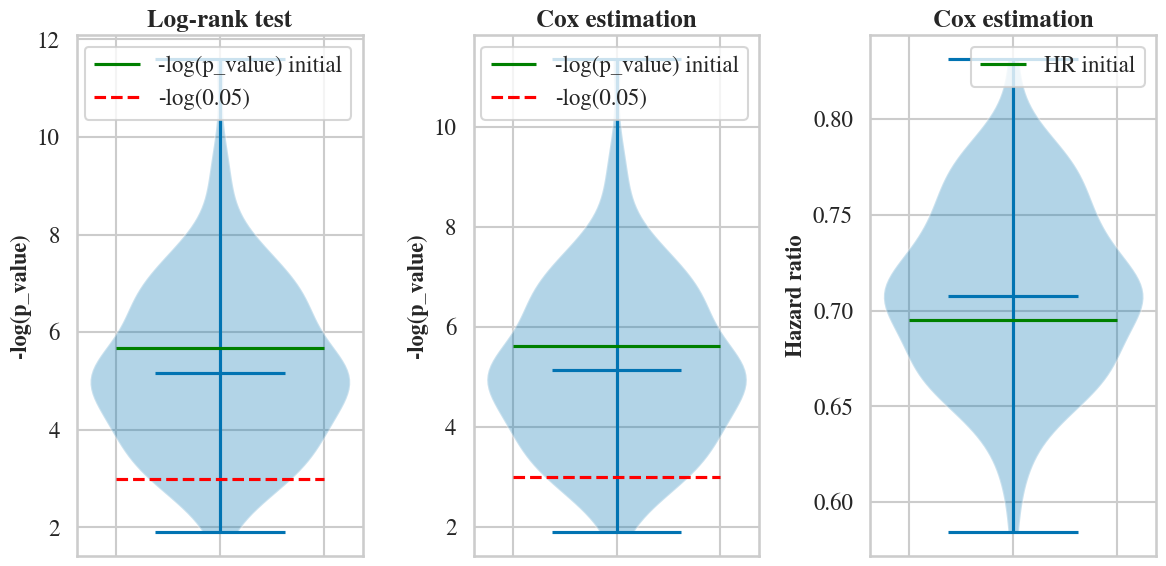

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.3. Metrics form synthcity: initial control data vs. all generated synthetic control groups

In [27]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

metrics = {
    'sanity': ['nearest_syn_neighbor_distance'],
    'stats': ['jensenshannon_dist', 'ks_test', 'survival_km_distance'],
    'performance': ['feat_rank_distance'],
    'detection': ['detection_xgb'],
    'privacy': ['k-map', 'distinct l-diversity', 'identifiability_score']
}
scores = ScoreEvaluator()
for j in range(n_generated_dataset):
    enable_reproducible_results(j)
    clear_cache()

    synthcity_dataloader_syn = SurvivalAnalysisDataLoader(list_df_gen_control[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=synthcity_dataloader_init, # can be dataloaders or dataframes
                                    X_syn=synthcity_dataloader_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=metrics, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores.add(key, mean_score[key], errors[key], duration[key], direction[key])

synthcity_score = scores.to_dataframe()
synthcity_score

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.nearest_syn_neighbor_distance.mean,0.101721,0.128783,0.114635,0.005365,0.114504,0.007114,100,0,0.00,minimize
stats.jensenshannon_dist.marginal,0.003629,0.007914,0.005463,0.000788,0.005400,0.000943,100,0,0.02,minimize
stats.ks_test.marginal,0.923409,0.946364,0.936689,0.004099,0.937045,0.005000,100,0,0.00,maximize
stats.survival_km_distance.optimism,-0.045278,0.047581,0.005412,0.016836,0.004985,0.023384,100,0,0.68,minimize
stats.survival_km_distance.abs_optimism,0.018193,0.050928,0.031516,0.006864,0.031105,0.010212,100,0,0.68,minimize
stats.survival_km_distance.sightedness,0.041748,0.041748,0.041748,0.000000,0.041748,0.000000,100,0,0.68,minimize
detection.detection_xgb.mean,0.959840,0.982955,0.972565,0.003945,0.973205,0.004713,100,0,0.18,minimize
privacy.k-map.score,6.000000,17.000000,12.110000,2.399562,12.000000,4.000000,100,0,0.02,maximize
privacy.distinct l-diversity.gt,8.000000,8.000000,8.000000,0.000000,8.000000,0.000000,100,0,0.05,maximize
privacy.distinct l-diversity.syn,4.000000,22.000000,13.420000,3.696431,13.000000,5.000000,100,0,0.05,maximize
